In [1]:
import itertools
import numpy as np
from scipy import sparse
from scipy import linalg as la
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

In [2]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["text.usetex"] = True

<h1><center>Parametric Model Reduction Example: Heat Equation with Piecewise Constant Diffusivity</center></h1>
<center>
Shane McQuarrie
</center>
<center>
CSE 392: SCIENTIF COMP MACH/DEEP LRN
</center>

## Problem Statement

Let $\Omega = [0,L]\subset \mathbb{R}$ be a spatial domain indicated by the variable $\omega$, and let $[0,T]\subset\mathbb{R}$ be a time domain with variable $t$.
Consider a one-dimensional parameterized heat equation with non-homogeneous Dirichlet boundary conditions,
$$
\begin{align*}
    \frac{\partial}{\partial t} x(\omega,t;\mathbf{p}) - \kappa(\omega)\frac{\partial^2}{\partial\omega^2}x(\omega,t;\mathbf{p}) &= 0
    & \omega &\in\Omega,\quad t\in[0,T],
    \\
    x(0,t;\mathbf{p}) = x(L,t;\mathbf{p}) &= u(t)
    & t &\in[0,T],
    \\
    x(\omega,0;\mathbf{p}) = e^{\alpha(\omega - 1)} + e^{-\alpha\omega} &- e^{-\alpha}
    & \omega &\in \Omega,
\end{align*}
$$
where $\kappa(\omega)$ is a piecewise-constant thermal diffusivity constant that depends on the spatial location:
$$
    \kappa(\omega)
    = \begin{cases}
        p_1 & \omega \le \bar{\omega},\\
        p_2 & \omega > \bar{\omega}.
    \end{cases}
$$
The parameters are therefore $\mathbf{p} = \begin{bmatrix}p_1 & p_2\end{bmatrix}^\mathsf{T}\in\mathbb{R}^2$.

Let $\{\omega_i\}_{i=0}^{n+1}$ be an equidistant grid of $n+2$ points on $\Omega$, i.e.,
$$
\begin{align*}
    0 &= \omega_0 < \omega_1 < \cdots < \omega_n < \omega_{n+1} = L
    &
    &\text{and}
    &
    \delta\omega &= \frac{L}{n+1} = \omega_{i+1} - \omega_{i},\quad i=1,\ldots,n-1.
\end{align*}
$$
Since the boundary conditions prescribe $x(\omega_0,t;\mathbf{p}) = x(\omega_{n+1},t;\mathbf{p}) = u(t)$, we wish to compute the state vector $\mathbf{x}(t,\mathbf{p}) = \begin{bmatrix} x(\omega_1,t;\mathbf{p}) & \cdots & x(\omega_n,t;\mathbf{p})\end{bmatrix}^\mathsf{T}\in\mathbb{R}^n$ for various $t\in[0,T]$ and $\mathbf{p}\in\mathbb{R}^2$.

Let $d$ be the index such that $\omega_{d} \le \bar{\omega} < \omega_{d+1}$.
Introducing the finite difference approximation
$$
\begin{align*}
    \frac{\partial^2}{\partial\omega^2}x(\omega,t) &\approx \frac{x(\omega-\delta\omega,t) - 2x(\omega,t) + x(\omega+\delta\omega,t)}{(\delta\omega)^2}
    % &
    % \Longrightarrow&
    % &
    % \frac{\partial^2}{\partial\omega^2}x(\omega_i,t) &\approx \frac{x(\omega_{i-1},t) - 2x(\omega_{i},t) + x(\omega_{i+1},t)}{(\delta\omega)^2}
    % \\
    &
    &\Longrightarrow
    &
    \frac{\partial^2}{\partial\omega^2}x_{i} &\approx \frac{x_{i-1} - 2x_{i} + x_{i+1}}{(\delta\omega)^2},
\end{align*}
$$
we obtain the semi-discrete system
$$
    \frac{d}{dt}\mathbf{x}(t;\mathbf{p}) = A(\mathbf{p})\mathbf{x}(t;\mathbf{p}) + B(\mathbf{p})u(t),
$$
with $A(\mathbf{p}) = p_1 A_1 + p_2 A_2$ and $ B(\mathbf{p}) = p_1 B_1 + p_2 B_2$, where
$$
\begin{align*}
    A_{1} &= \left[\begin{array}{c|c}
        %\arrayrulecolor{lightgray}
        \Delta_{d\times d} & 0 \\ \hline 0 & 0
    \end{array}\right] \in\mathbb{R}^{n\times n},
    &
    A_{2} &= \left[\begin{array}{c|c}
        %\arrayrulecolor{lightgray}
        0 & 0 \\ \hline 0 & \Delta_{(n-d)\times (n-d)}
    \end{array}\right] \in\mathbb{R}^{n\times n},
    &
    B_1 &= \frac{1}{(\delta\omega)^2}\left[\begin{array}{c}1 \\ 0 \\ \vdots \\ 0 \\ 0\end{array}\right],
    &
    B_2 &= \frac{1}{(\delta\omega)^2}\left[\begin{array}{c}0 \\ 0 \\ \vdots \\ 0 \\ 1\end{array}\right],
\end{align*}
$$
$$
    \Delta_{a\times a} = \frac{1}{(\delta\omega)^2}\left[\begin{array}{ccccc}
        %\arrayrulecolor{lightgray}
        -2 & 1 & & & \\
        1 & -2 & 1 & & \\
        & \ddots & \ddots & \ddots & \\
        & & 1 & -2 & 1 \\
        & & & 1 & -2 \\
    \end{array}\right] \in\mathbb{R}^{a\times a}.
$$

## Snapshot Data Generation

For simplicity, let $L = T = 1$ and $u(t) = 1$.
To construct a reduced-order model general $\mathbf{p}$, we take equally distributed samples $\{\mathbf{p}_i\}_{i=1}^{s}$ and simulate, for each $\mathbf{p}_{i}$, the corresponding full-order systems, resulting in a set of snapshot matrices $X(\mathbf{p}_1),\ldots,X(\mathbf{p}_{s})\in\mathbb{R}^{n\times k}$, where the $j$th column of $X(\mathbf{p}_{i})$ is the solution trajectory with $\mathbf{p} = \mathbf{p}_{i}$ at time $t_j$.
For this experiment, we choose $\alpha=100$ and $\bar{\omega} = 0.6$.

In [3]:
# Construct the spatial domain.
L = 1                           # Spatial domain length.
n = 2**10 - 1                   # Spatial grid size.
w_all = np.linspace(0, L, n+2)  # Full spatial grid.
w = w_all[1:-1]                 # Interior spatial grid.
dw = w[1] - w[0]                # Spatial resolution.

# Construct the temporal domain.
T = 1                           # Temporal domain length (final simulation time).
k = T*10**3+1                   # Temporal grid size.
t = np.linspace(0, T, k)        # Temporal grid.
dt = t[1] - t[0]                # Temporal resolution.

print(f"Spatial step size dw = {dw}")
print(f"Temporal step size dt = {dt}")

Spatial step size dw = 0.0009765625
Temporal step size dt = 0.001


In [4]:
wbar = 0.6
d = np.searchsorted(w, wbar) - 1
print(f"{w[d]} <= {wbar} < {w[d+1]}: {w[d] <= wbar < w[d+1]}")

0.599609375 <= 0.6 < 0.6005859375: True


In [5]:
# Construct general state matrix A.
dw2inv = 1 / dw**2
diags = np.array([1, -2, 1]) * dw2inv
A1 = sparse.diags(diags, [-1,0,1], (n,n)).todok()
A2 = A1.copy()
A1[d:] = 0
A2[:d] = 0
A1 = A1.tocsc()
A2 = A2.tocsc()

# Construct general input term B.
B1 = np.zeros_like(w)
B2 = B1.copy()
B1[0], B2[-1] = dw2inv, dw2inv

# Construct the initial condition.
alpha = 100
x0 = np.exp(alpha*(w-1)) + np.exp(-alpha*w) - np.exp(-alpha)

print(f"shape of A1:\t{A1.shape}")
print(f"shape of A2:\t{A2.shape}")
print(f"shape of B1:\t{B1.shape}")
print(f"shape of B2:\t{B2.shape}")
print(f"shape of x0:\t{x0.shape}")

shape of A1:	(1023, 1023)
shape of A2:	(1023, 1023)
shape of B1:	(1023,)
shape of B2:	(1023,)
shape of x0:	(1023,)


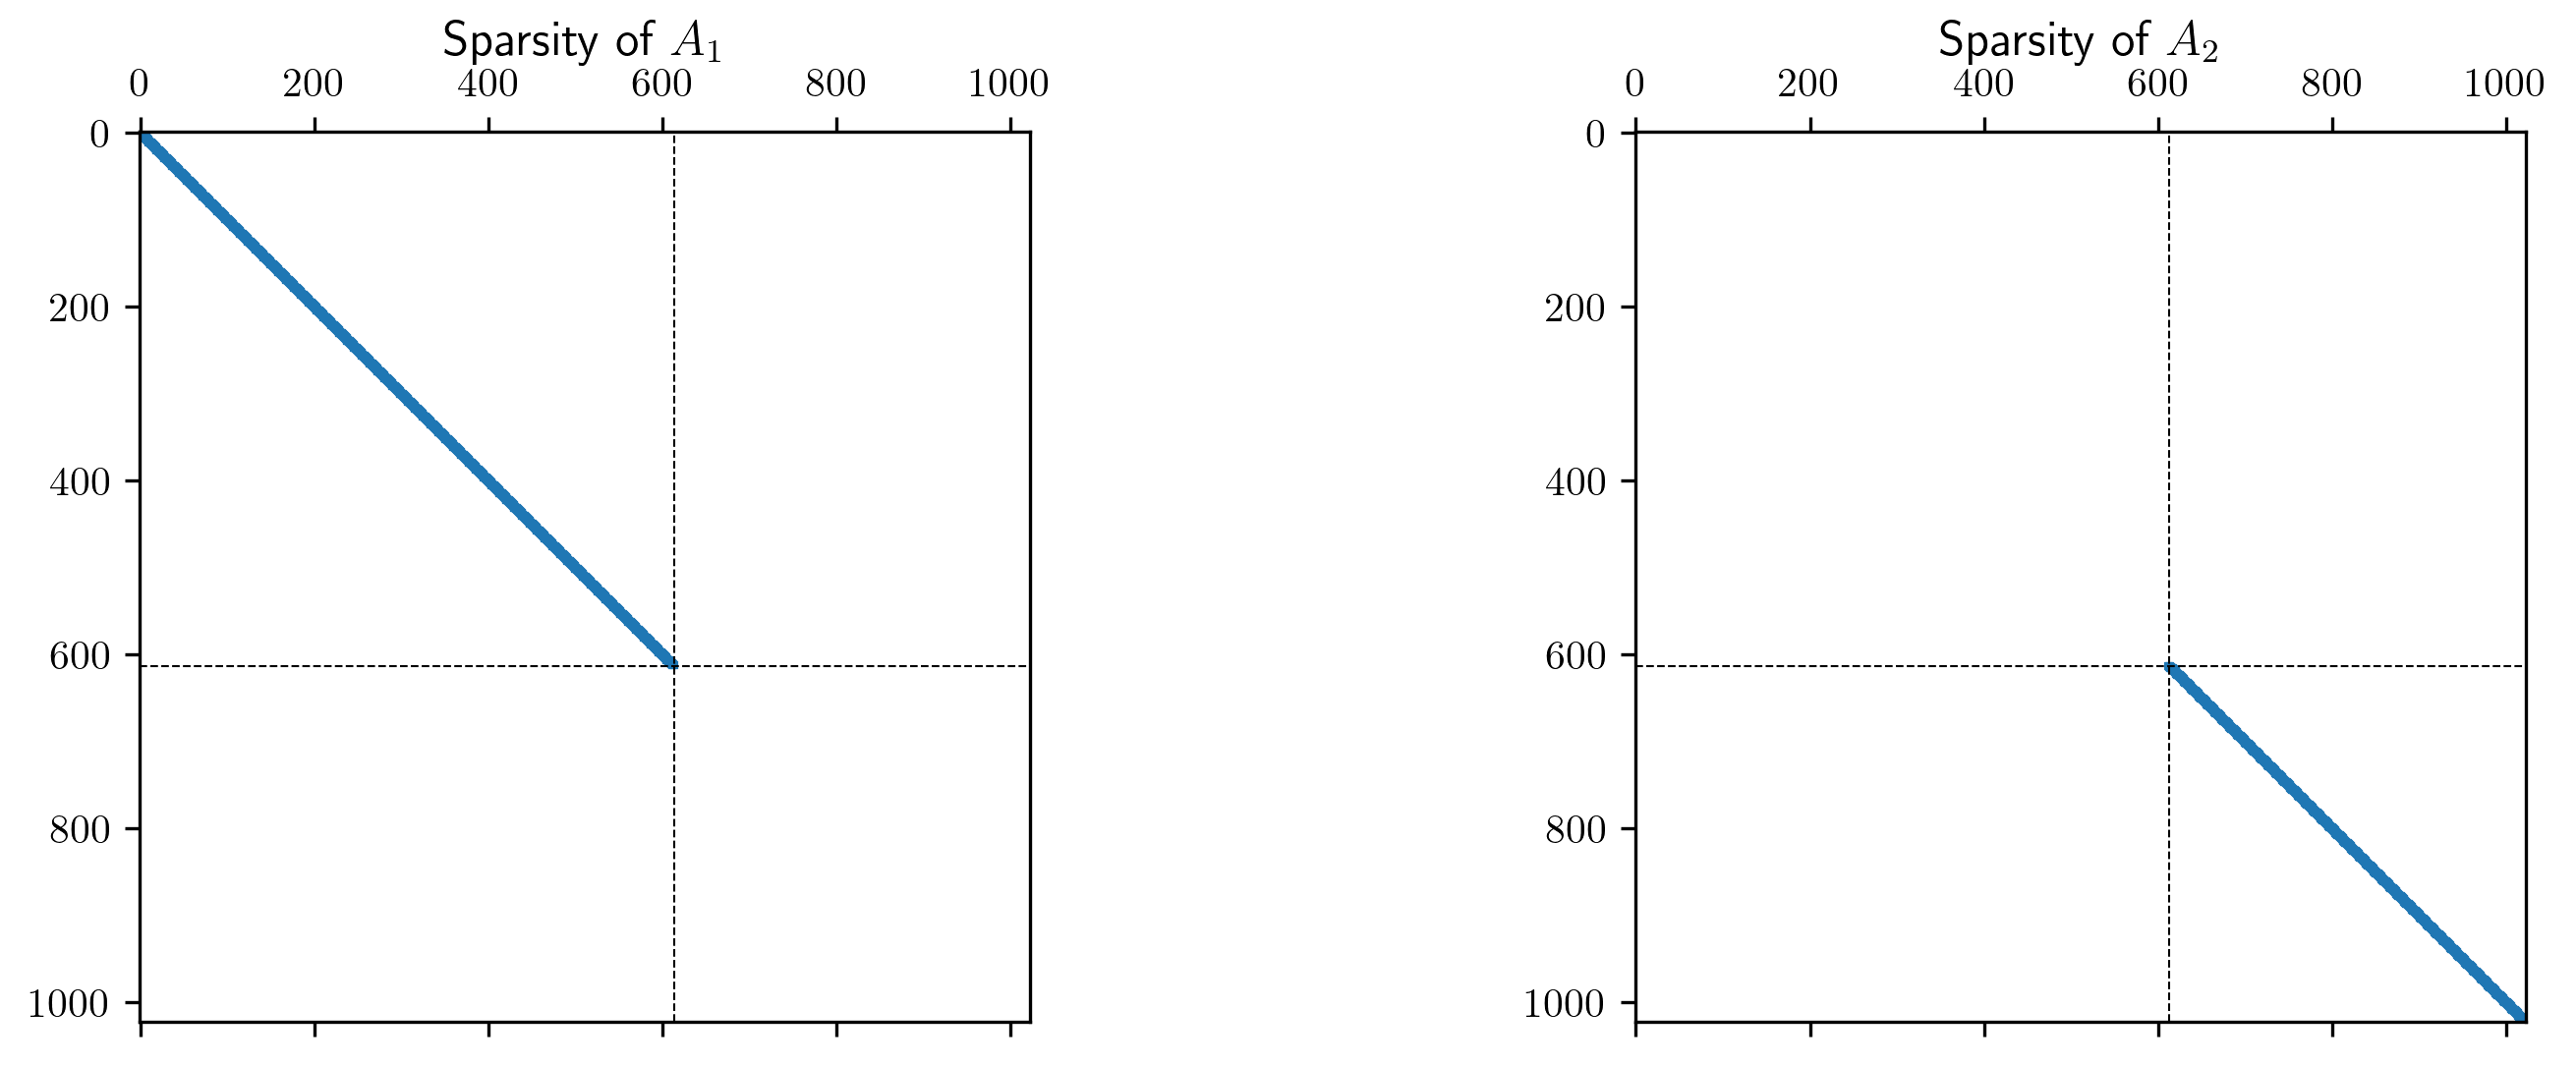

In [6]:
fig, [ax1, ax2] = plt.subplots(1, 2)

ax1.spy(A1, ms=1)
ax1.axhline(d, c='k', ls='--', lw=.5)
ax1.axvline(d, c='k', ls='--', lw=.5)
ax1.set_title(r"Sparsity of $A_1$")

ax2.spy(A2, ms=1)
ax2.axhline(d, c='k', ls='--', lw=.5)
ax2.axvline(d, c='k', ls='--', lw=.5)
ax2.set_title(r"Sparsity of $A_2$")
plt.show()

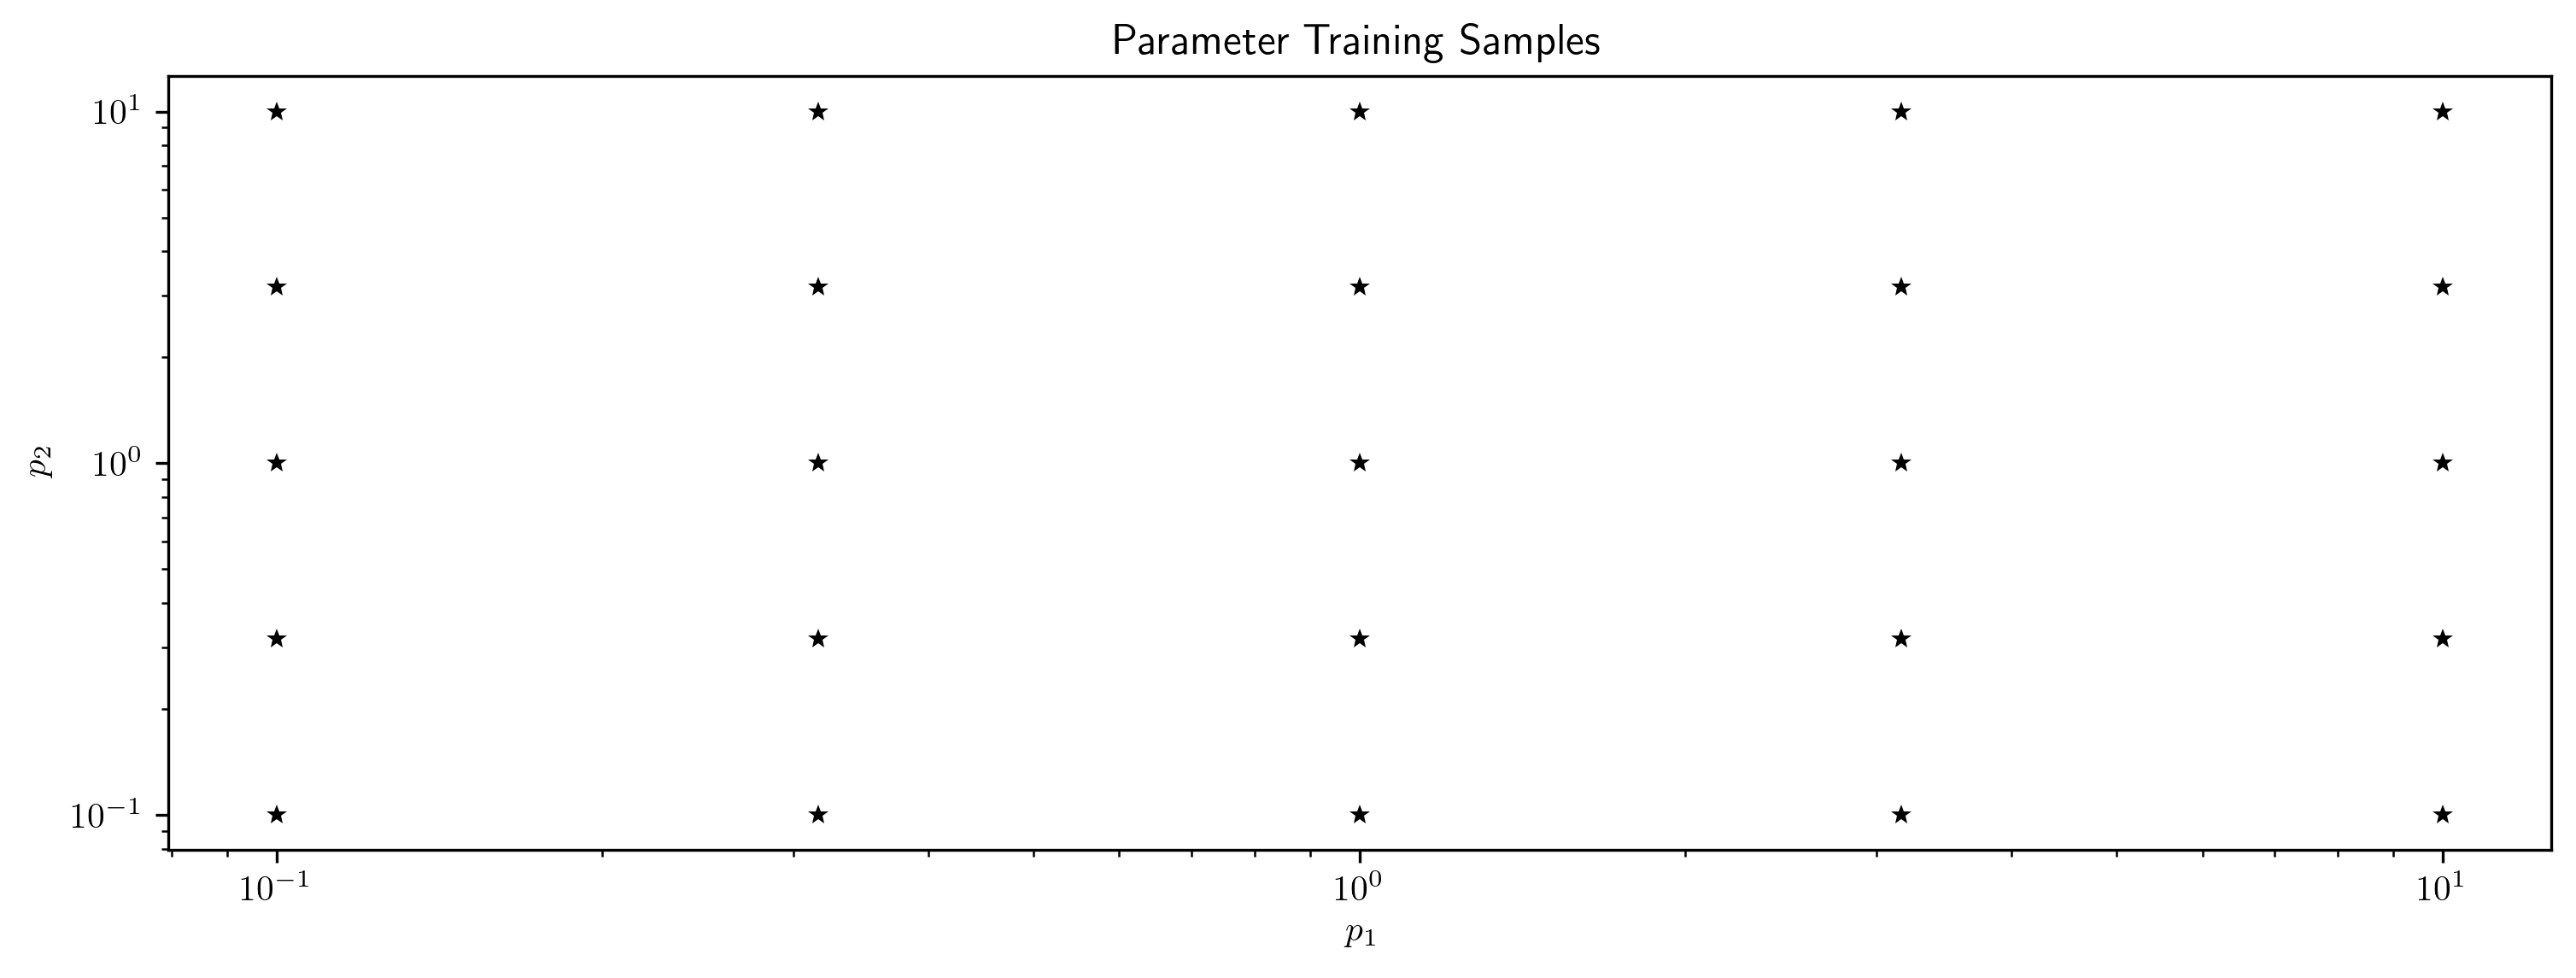

In [7]:
# Get a grid of samples.
p = np.array(list(itertools.product(np.logspace(-1,1,5), repeat=2)))
s = p.shape[0]
plt.loglog(p[:,0], p[:,1], 'k*', mew=0)
plt.title("Parameter Training Samples")
plt.xlabel(r"$p_1$")
plt.ylabel(r"$p_2$")
plt.show()

In [8]:
def FOM(p):
    """Do a full-order model solve for the parameter p."""
    # Precompute the state / input matrices based off of the parameter p.
    p1, p2 = p
    A = p1*A1 + p2*A2
    B = p1*B1 + p2*B2
    
    # Solve the resulting system.
    f = lambda t,x: A @ x + B
    return solve_ivp(f, [0,T], x0, method="BDF", t_eval=t).y

In [9]:
%%time

# Compute snapshots by simulating the FOM (expensive).
Xs = [FOM(pi) for pi in p]

CPU times: user 51.2 s, sys: 2.28 s, total: 53.5 s
Wall time: 14.5 s


Let's look at a few of the snapshot sets.

In [10]:
def plot_heat_data(Z, title="", seps=(), ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12,4))

    # Plot a few snapshots.
    for sep in seps:
        ax.axvline(sep, c="k", ls="--", lw=1)    
    color = iter(plt.cm.viridis(np.linspace(.25, 1, 6)))
    for j in [0, 20, 80, 160, 320, 640]:
        x_all = np.concatenate([[1], Z[:,j], [1]])
        ax.plot(w_all, x_all, color=next(color), label=rf"$x(\omega,t_{{{j}}})$")
    
    ax.set_xlim(0, 1)
    ax.set_xlabel(r"$\omega$")
    ax.set_ylabel(r"$x(\omega,t;\mathbf{p})$")
    ax.set_title(title)

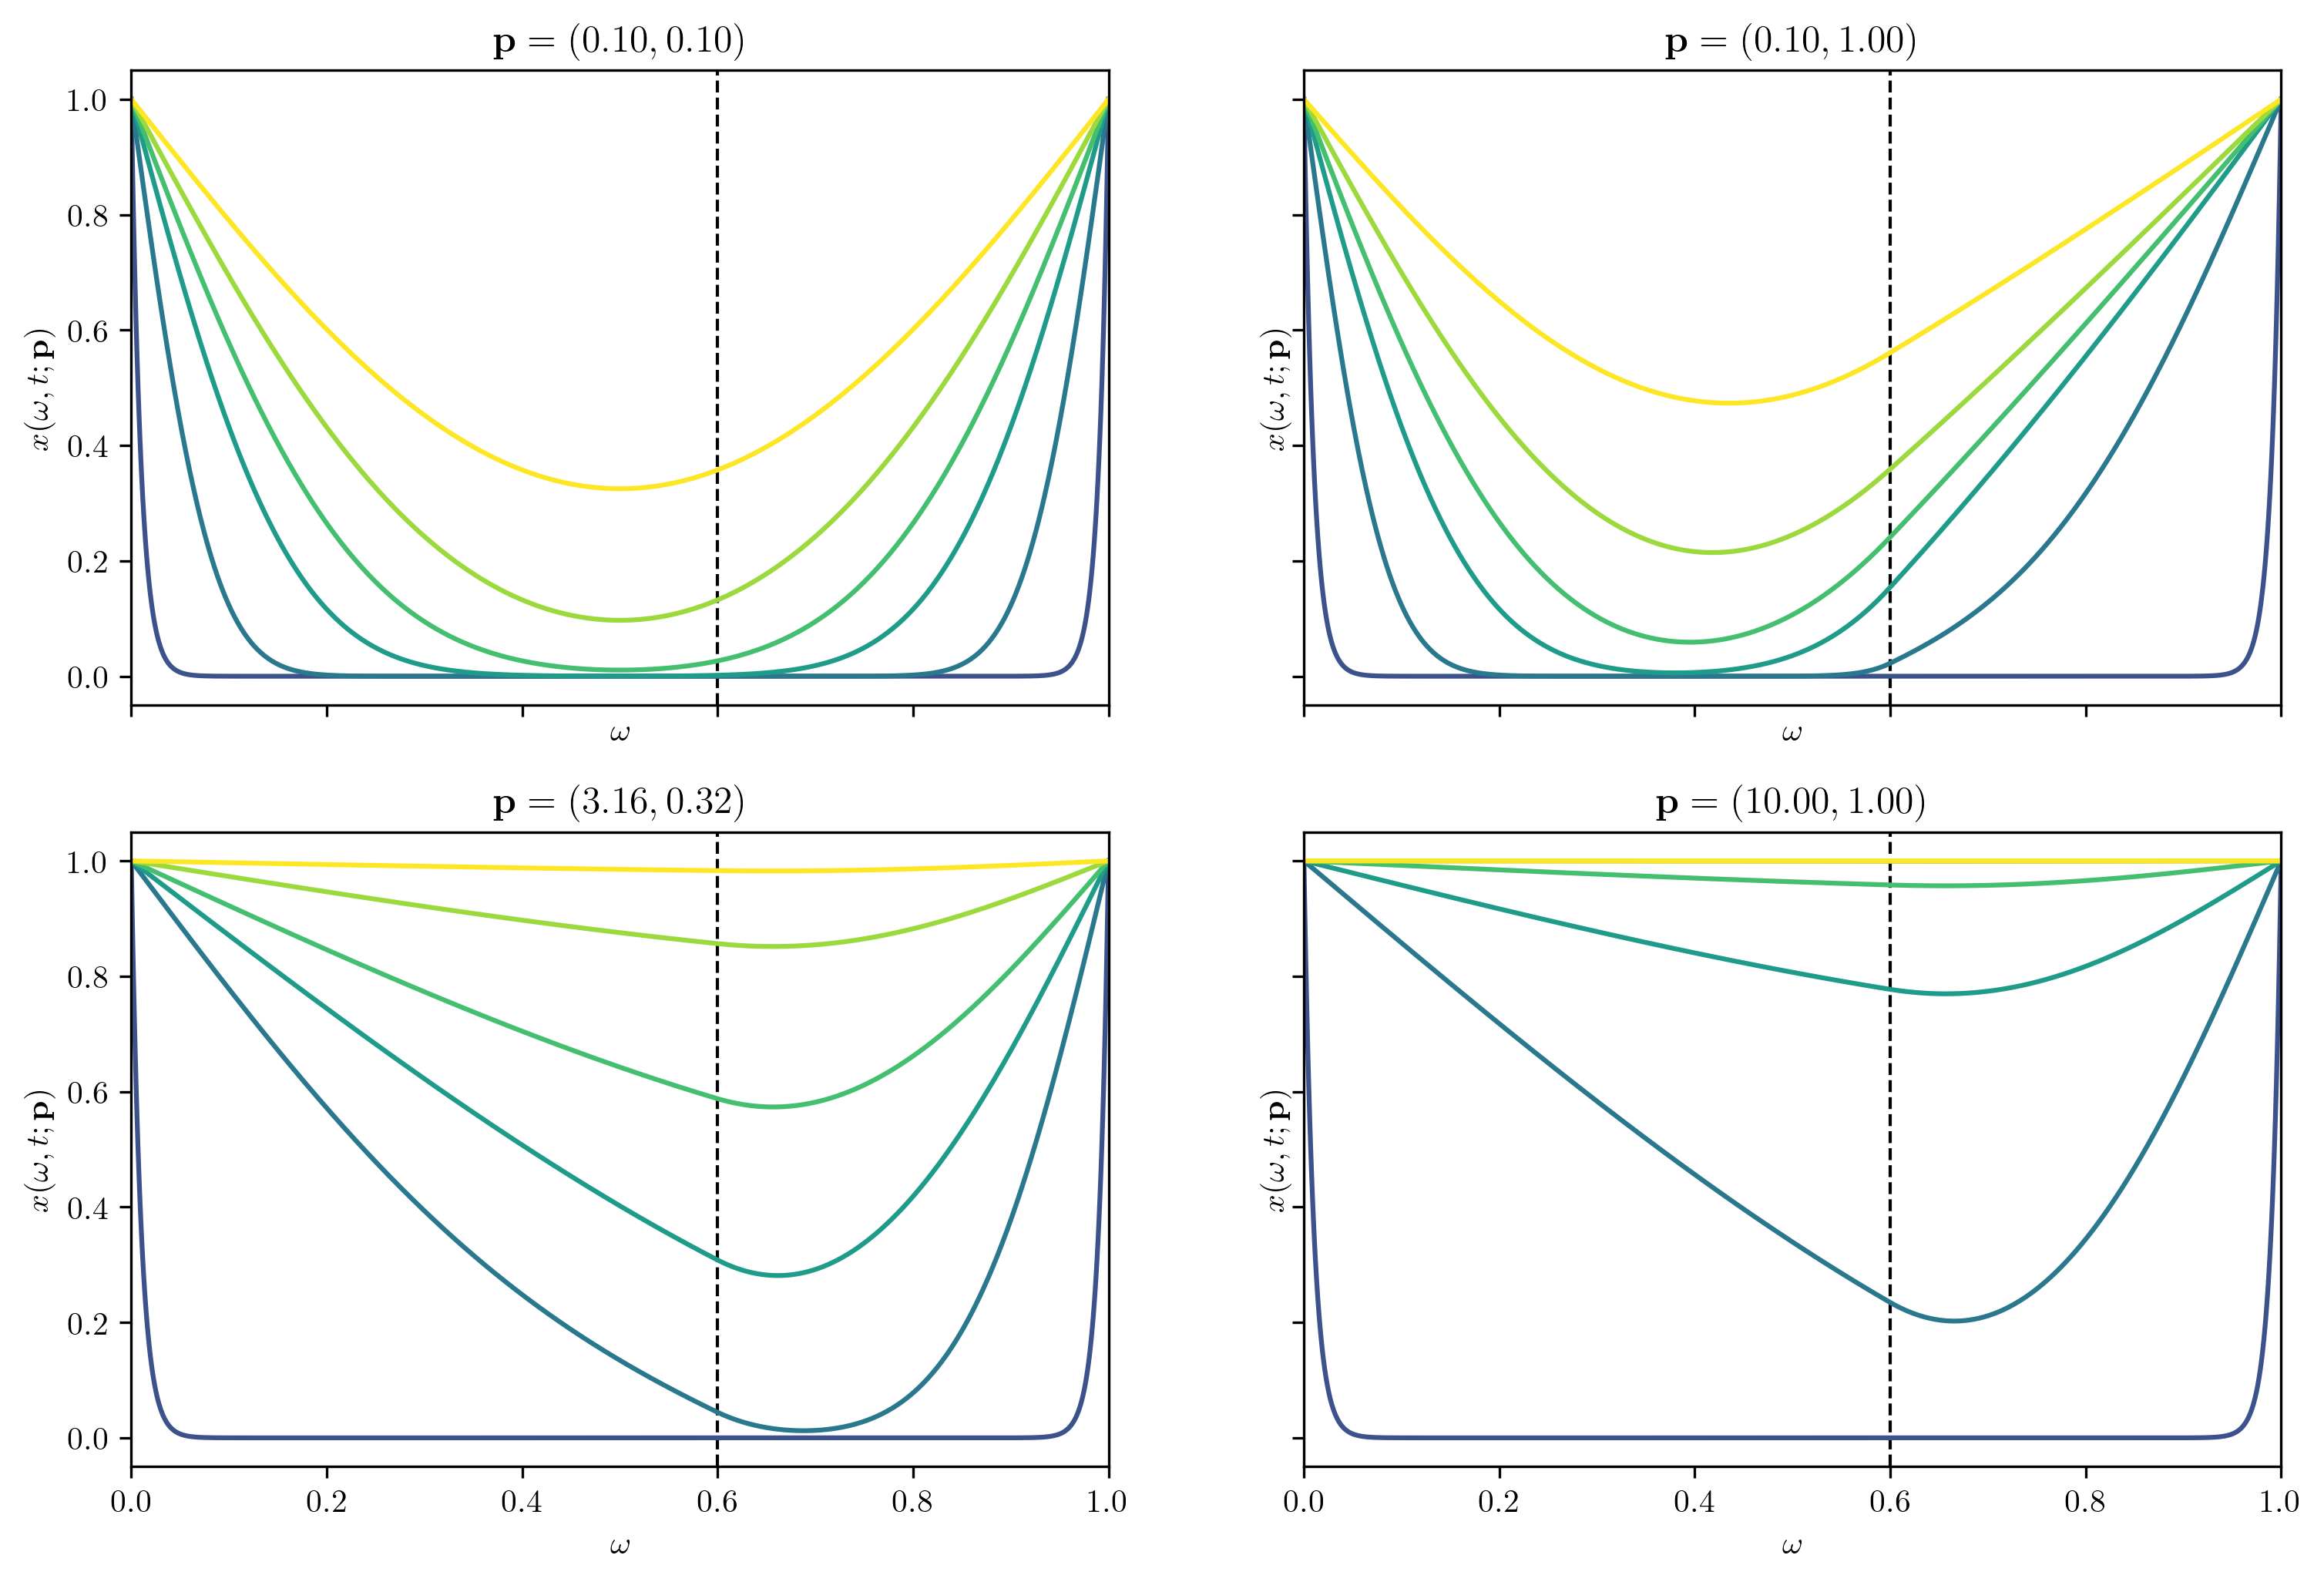

In [11]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,8))

plot_heat_data(Xs[0],  fr"$\mathbf{{p}} = ({p[0,0]:.2f},  {p[0,1]:.2f})$",  [wbar], axes[0,0])
plot_heat_data(Xs[2],  fr"$\mathbf{{p}} = ({p[2,0]:.2f},  {p[2,1]:.2f})$",  [wbar], axes[0,1])
plot_heat_data(Xs[16], fr"$\mathbf{{p}} = ({p[16,0]:.2f}, {p[16,1]:.2f})$", [wbar], axes[1,0])
plot_heat_data(Xs[-3], fr"$\mathbf{{p}} = ({p[-3,0]:.2f}, {p[-3,1]:.2f})$", [wbar], axes[1,1])

Next, we construct a (global) POD basis from the concatenated snapshots,
$$
    V_r = \texttt{pod}\left(\begin{bmatrix}X(\mathbf{p}_1) & \cdots & X(\mathbf{p}_s)\end{bmatrix}\right)
$$

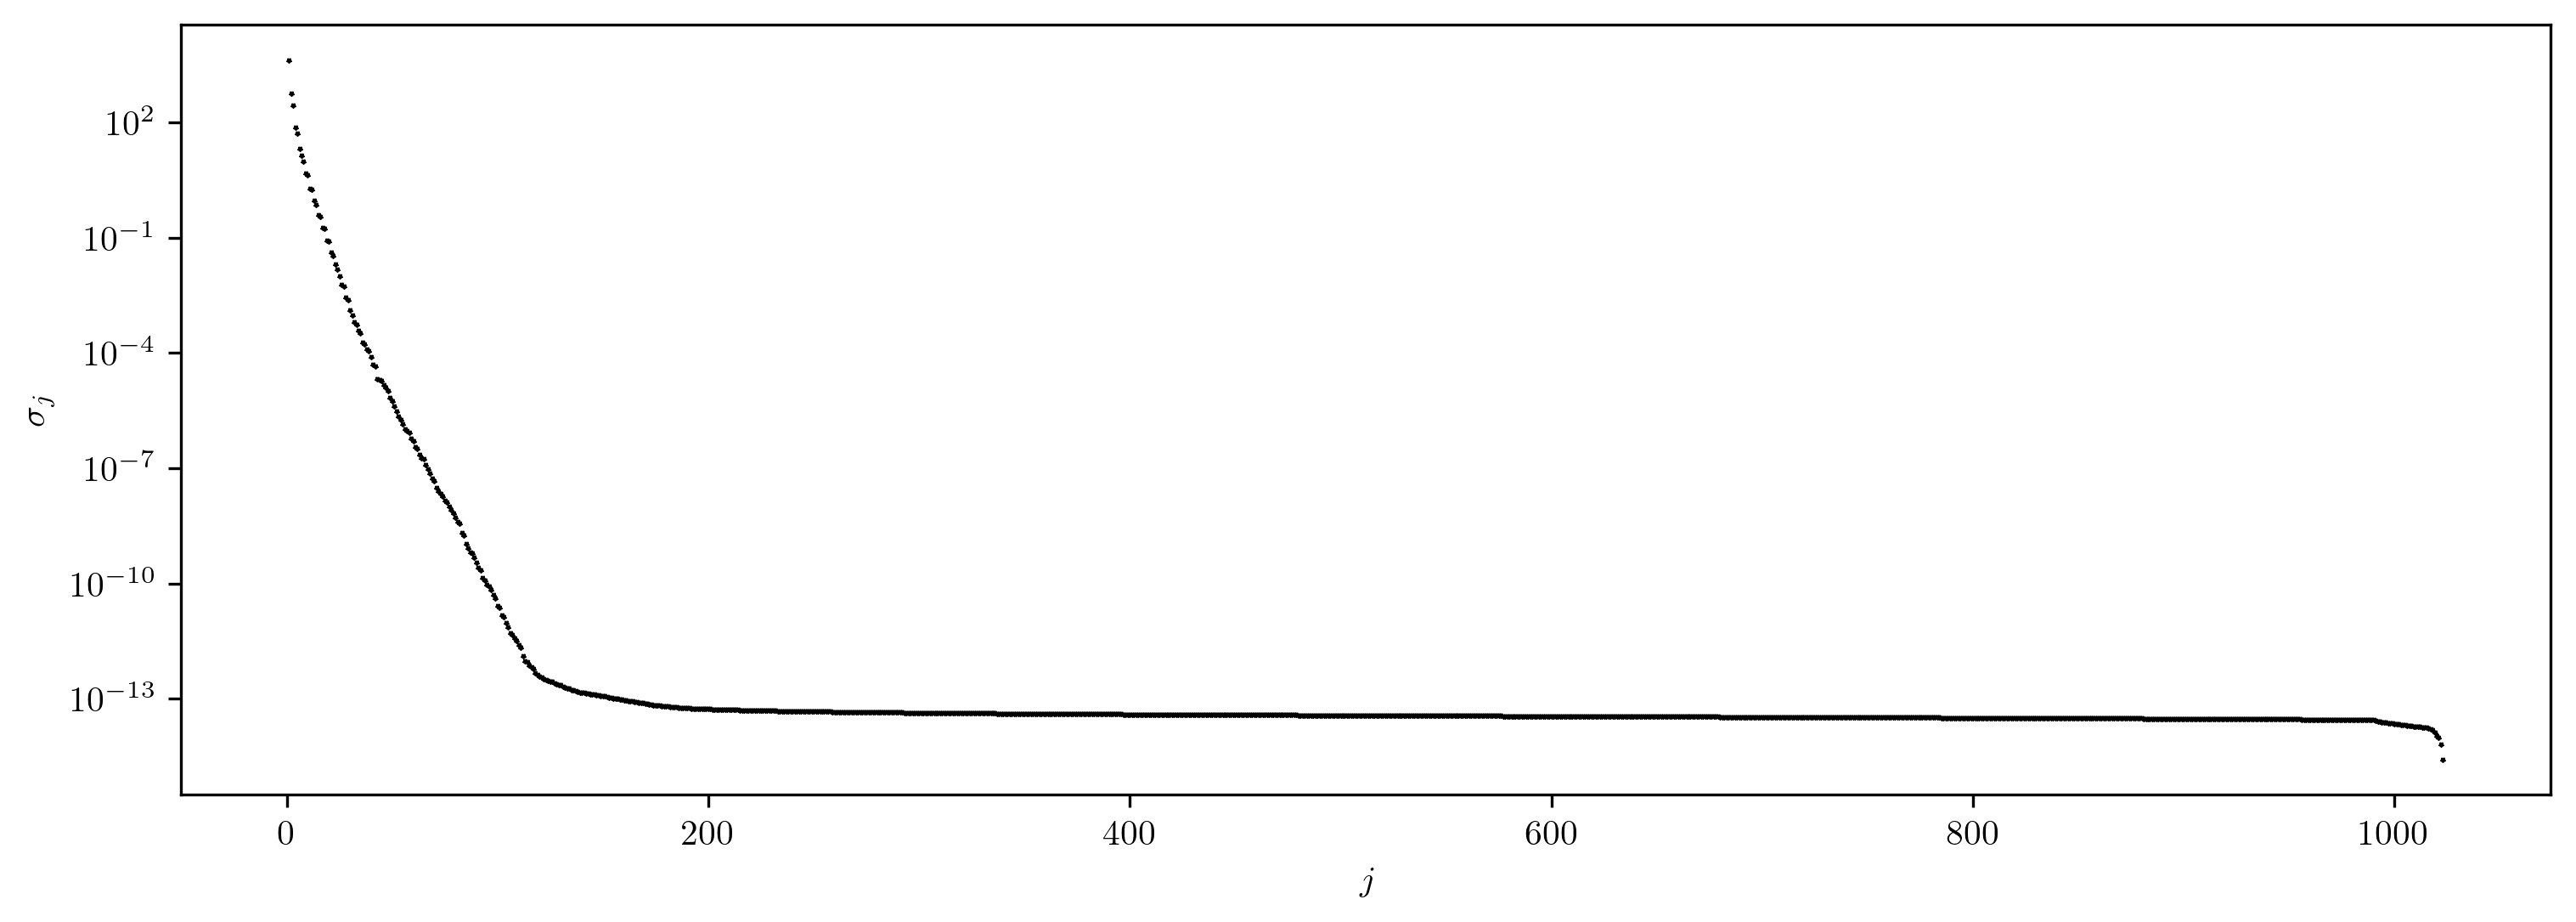

In [12]:
X_all = np.hstack(Xs)
svals = la.svdvals(X_all)
plt.semilogy(np.arange(1,svals.shape[0]+1), svals, 'k*', ms=1)
plt.xlabel(r"$j$")
plt.ylabel(r"$\sigma_j$")
plt.show()

In [13]:
r = np.argmin((np.cumsum(svals**2) / np.sum(svals**2)) < .99999999) + 1
r

16

In [14]:
def pod_basis(X, r):
    return la.svd(X)[0][:,:r] # This could also be replaced with a randomized SVD.

In [15]:
# Compute the POD basis from the snapshots (expensive, but only needed once).
Vr = pod_basis(X_all, r)

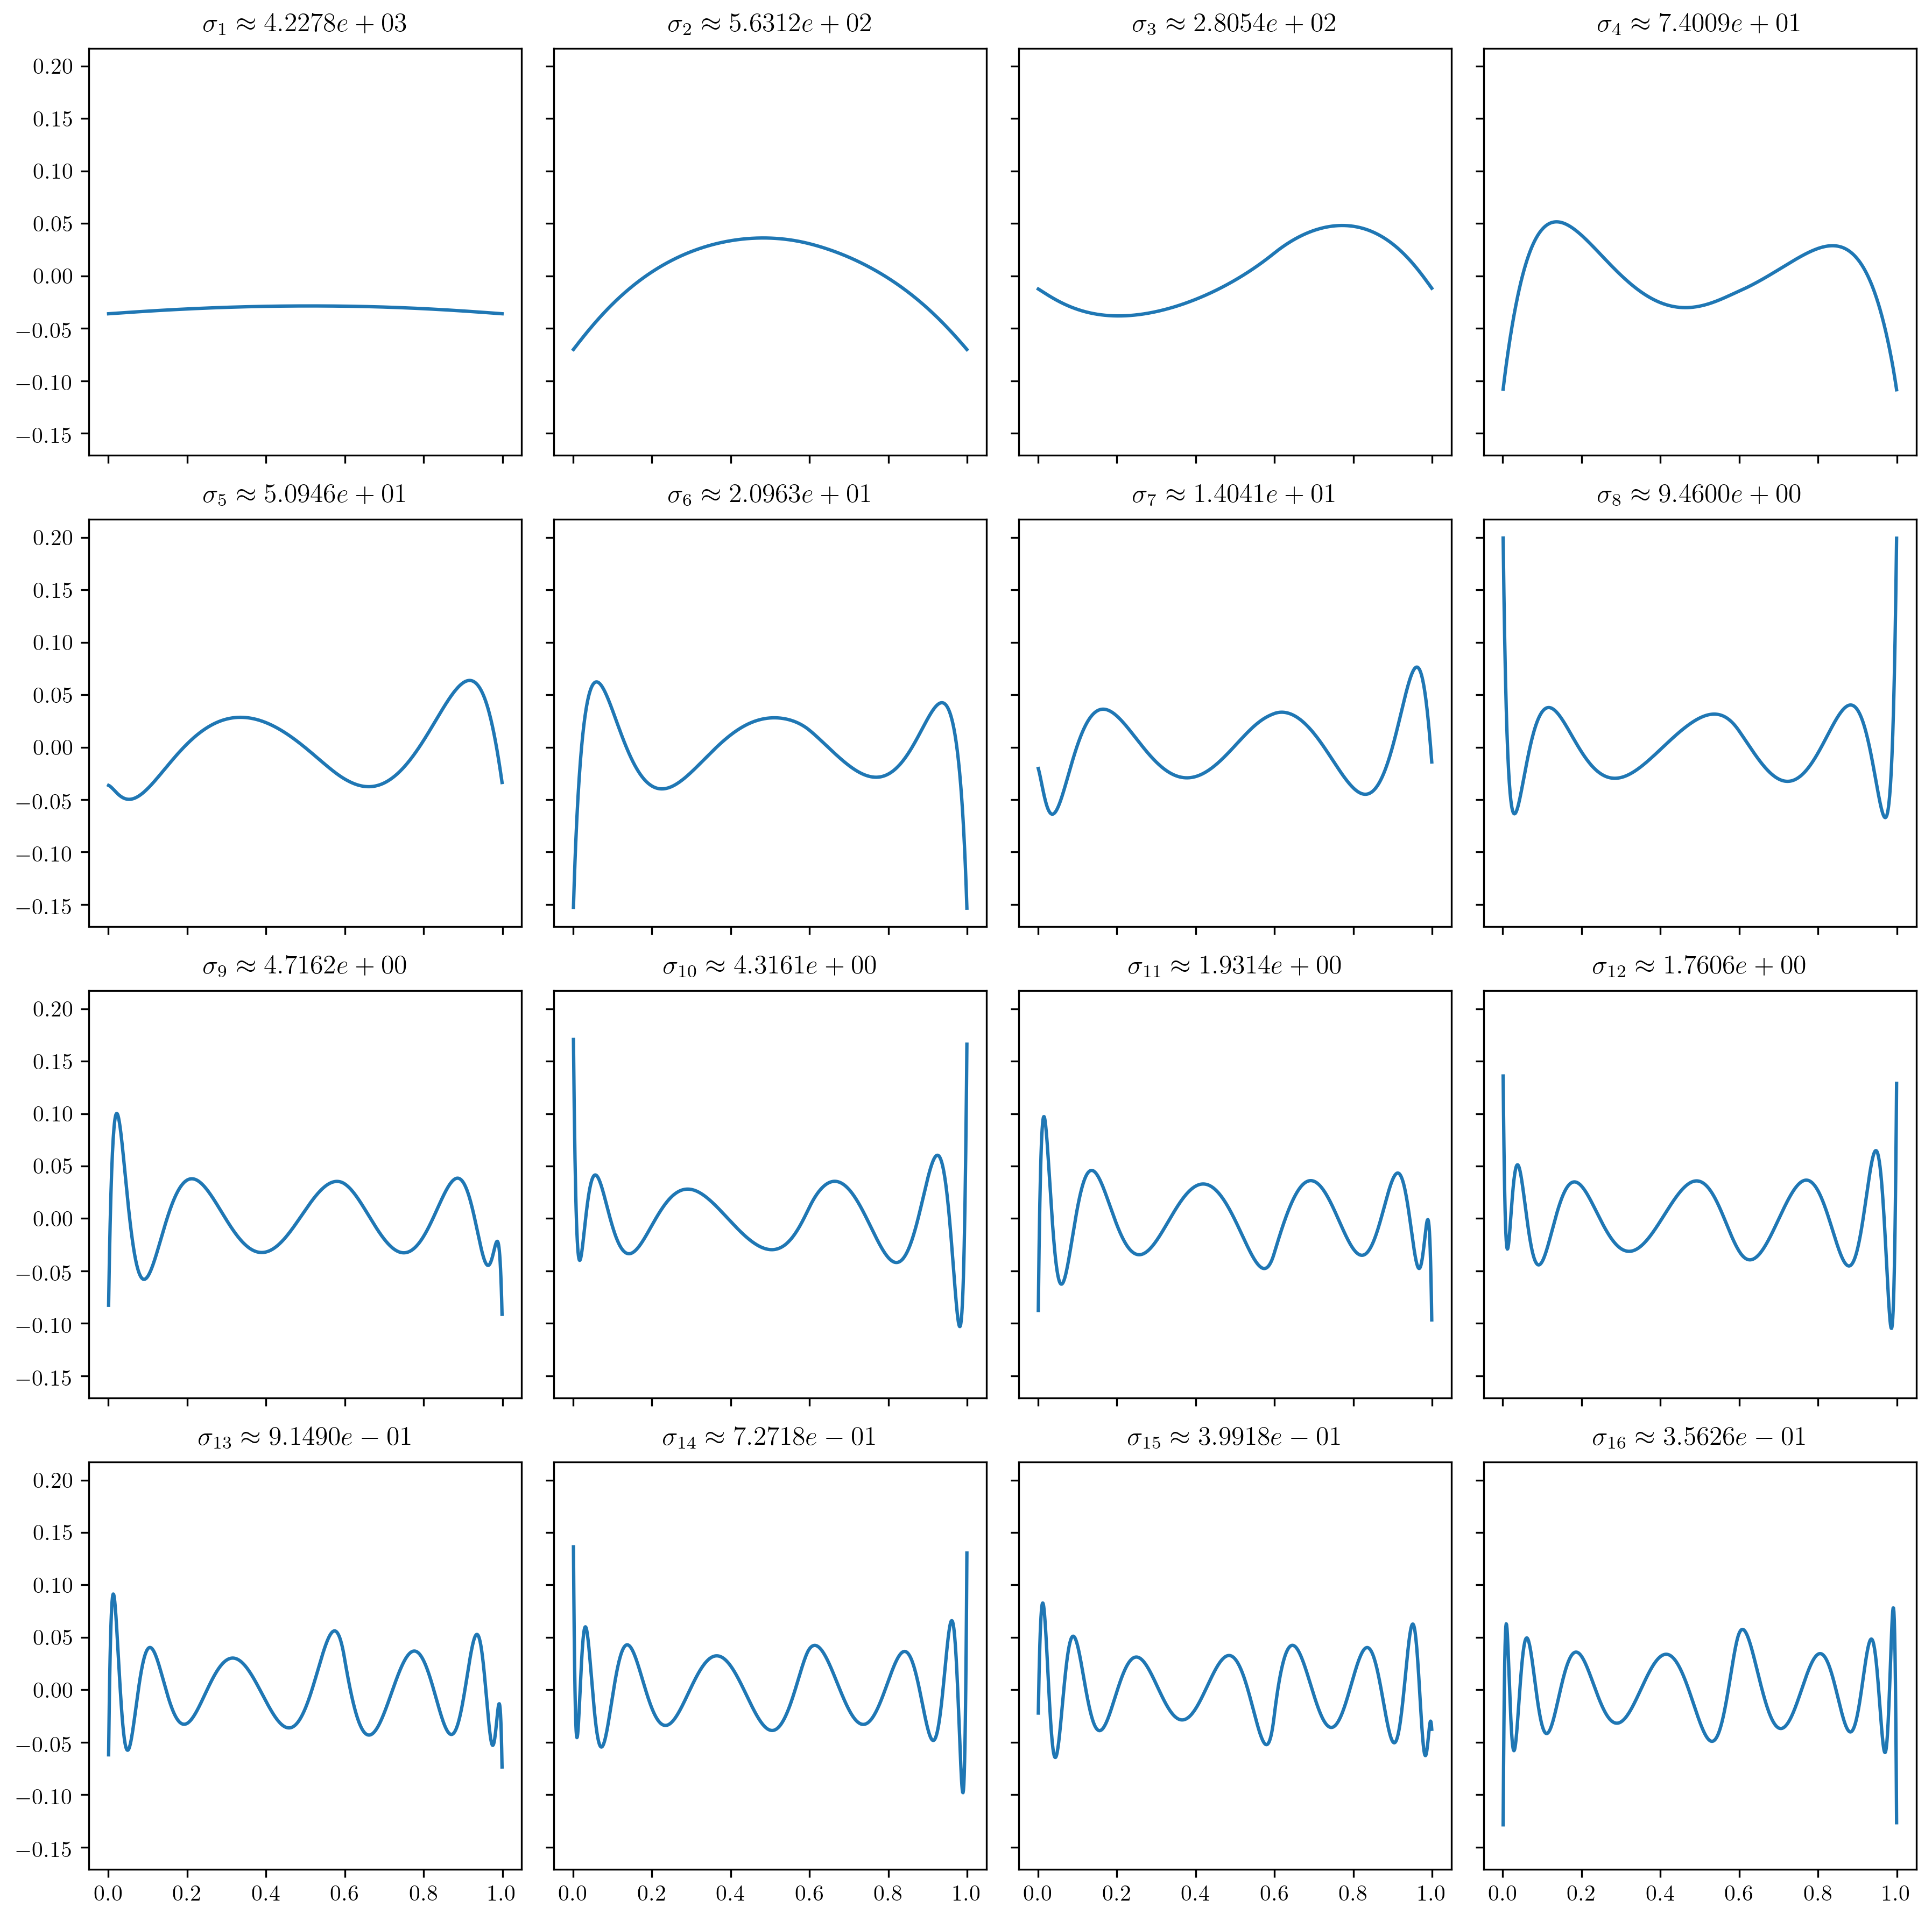

In [16]:
# Visualize the computed basis vectors; all solutions to the ROM are linear combinations of these vectors.

fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12,12))
for j, ax in enumerate(axes.flat):
    ax.plot(w, Vr[:,j])
    ax.set_title(rf"$\sigma_{{{j+1}}}\approx {svals[j]:.4e}$")
plt.tight_layout()
plt.show()

Now we can construct the reduced-order model.

In [17]:
# Project the operators using the POD basis.
A1_ = Vr.T @ A1 @ Vr
A2_ = Vr.T @ A2 @ Vr
B1_ = Vr.T @ B1
B2_ = Vr.T @ B2
x0_ = Vr.T @ x0

def ROM(p):
    """Do a reduced-order solve for the parameter p."""
    # Precompute the (small) state and input matrices from p.
    p1, p2 = p
    A_ = p1*A1_ + p2*A2_
    B_ = p1*B1_ + p2*B2_
    
    # Simulate the system and map the results to the original space.
    f_ = lambda t,x_: A_ @ x_ + B_
    return Vr @ solve_ivp(f_, [0,T], x0_, method="BDF", t_eval=t).y

In [18]:
%%time

Xs_ROM = [ROM(pi) for pi in p]

CPU times: user 4.44 s, sys: 273 ms, total: 4.71 s
Wall time: 1.2 s


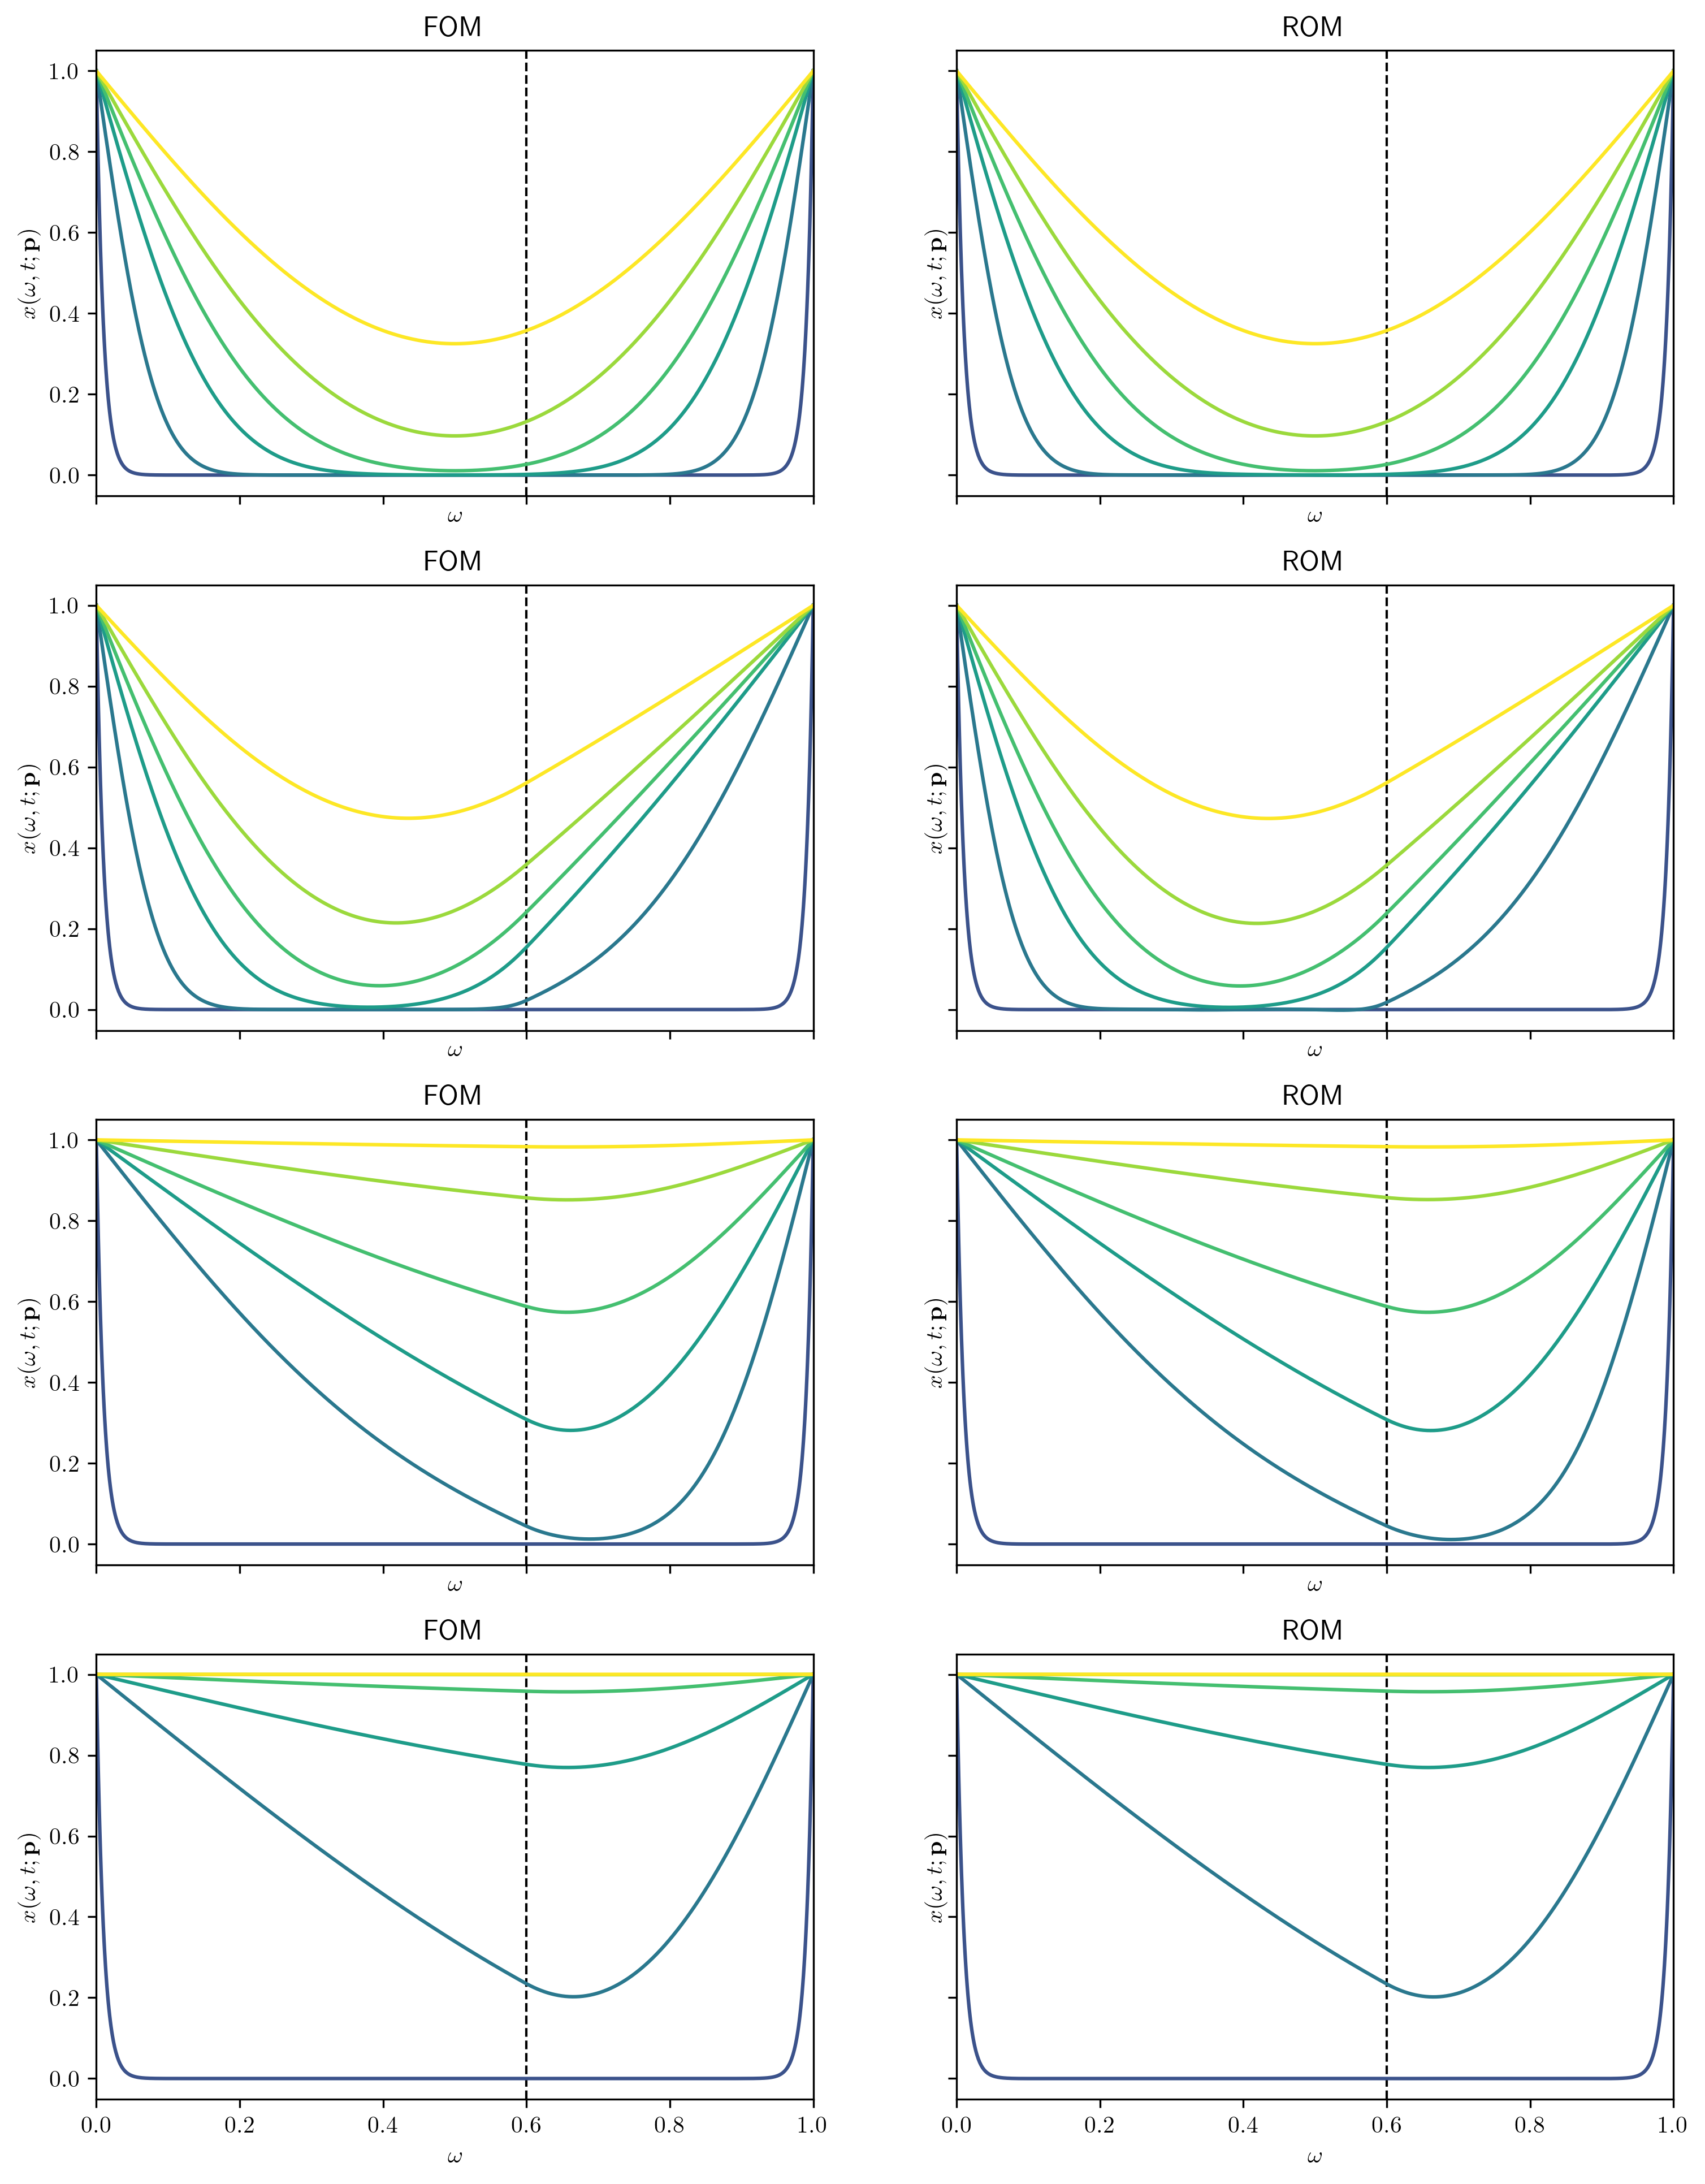

In [19]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(12,16))

plot_heat_data(Xs[0],      fr"FOM", [wbar], axes[0,0])
plot_heat_data(Xs_ROM[0],  fr"ROM", [wbar], axes[0,1])

plot_heat_data(Xs[2],      fr"FOM", [wbar], axes[1,0])
plot_heat_data(Xs_ROM[2],  fr"ROM", [wbar], axes[1,1])

plot_heat_data(Xs[16],     fr"FOM", [wbar], axes[2,0])
plot_heat_data(Xs_ROM[16], fr"ROM", [wbar], axes[2,1])

plot_heat_data(Xs[-3],     fr"FOM", [wbar], axes[3,0])
plot_heat_data(Xs_ROM[-3], fr"ROM", [wbar], axes[3,1])

We get identical results (in the eyeball norm) for the test parameters, and the ROM is about 10 times faster than the FOM.
The ROM can also handle new parameters $\mathbf{p}$.

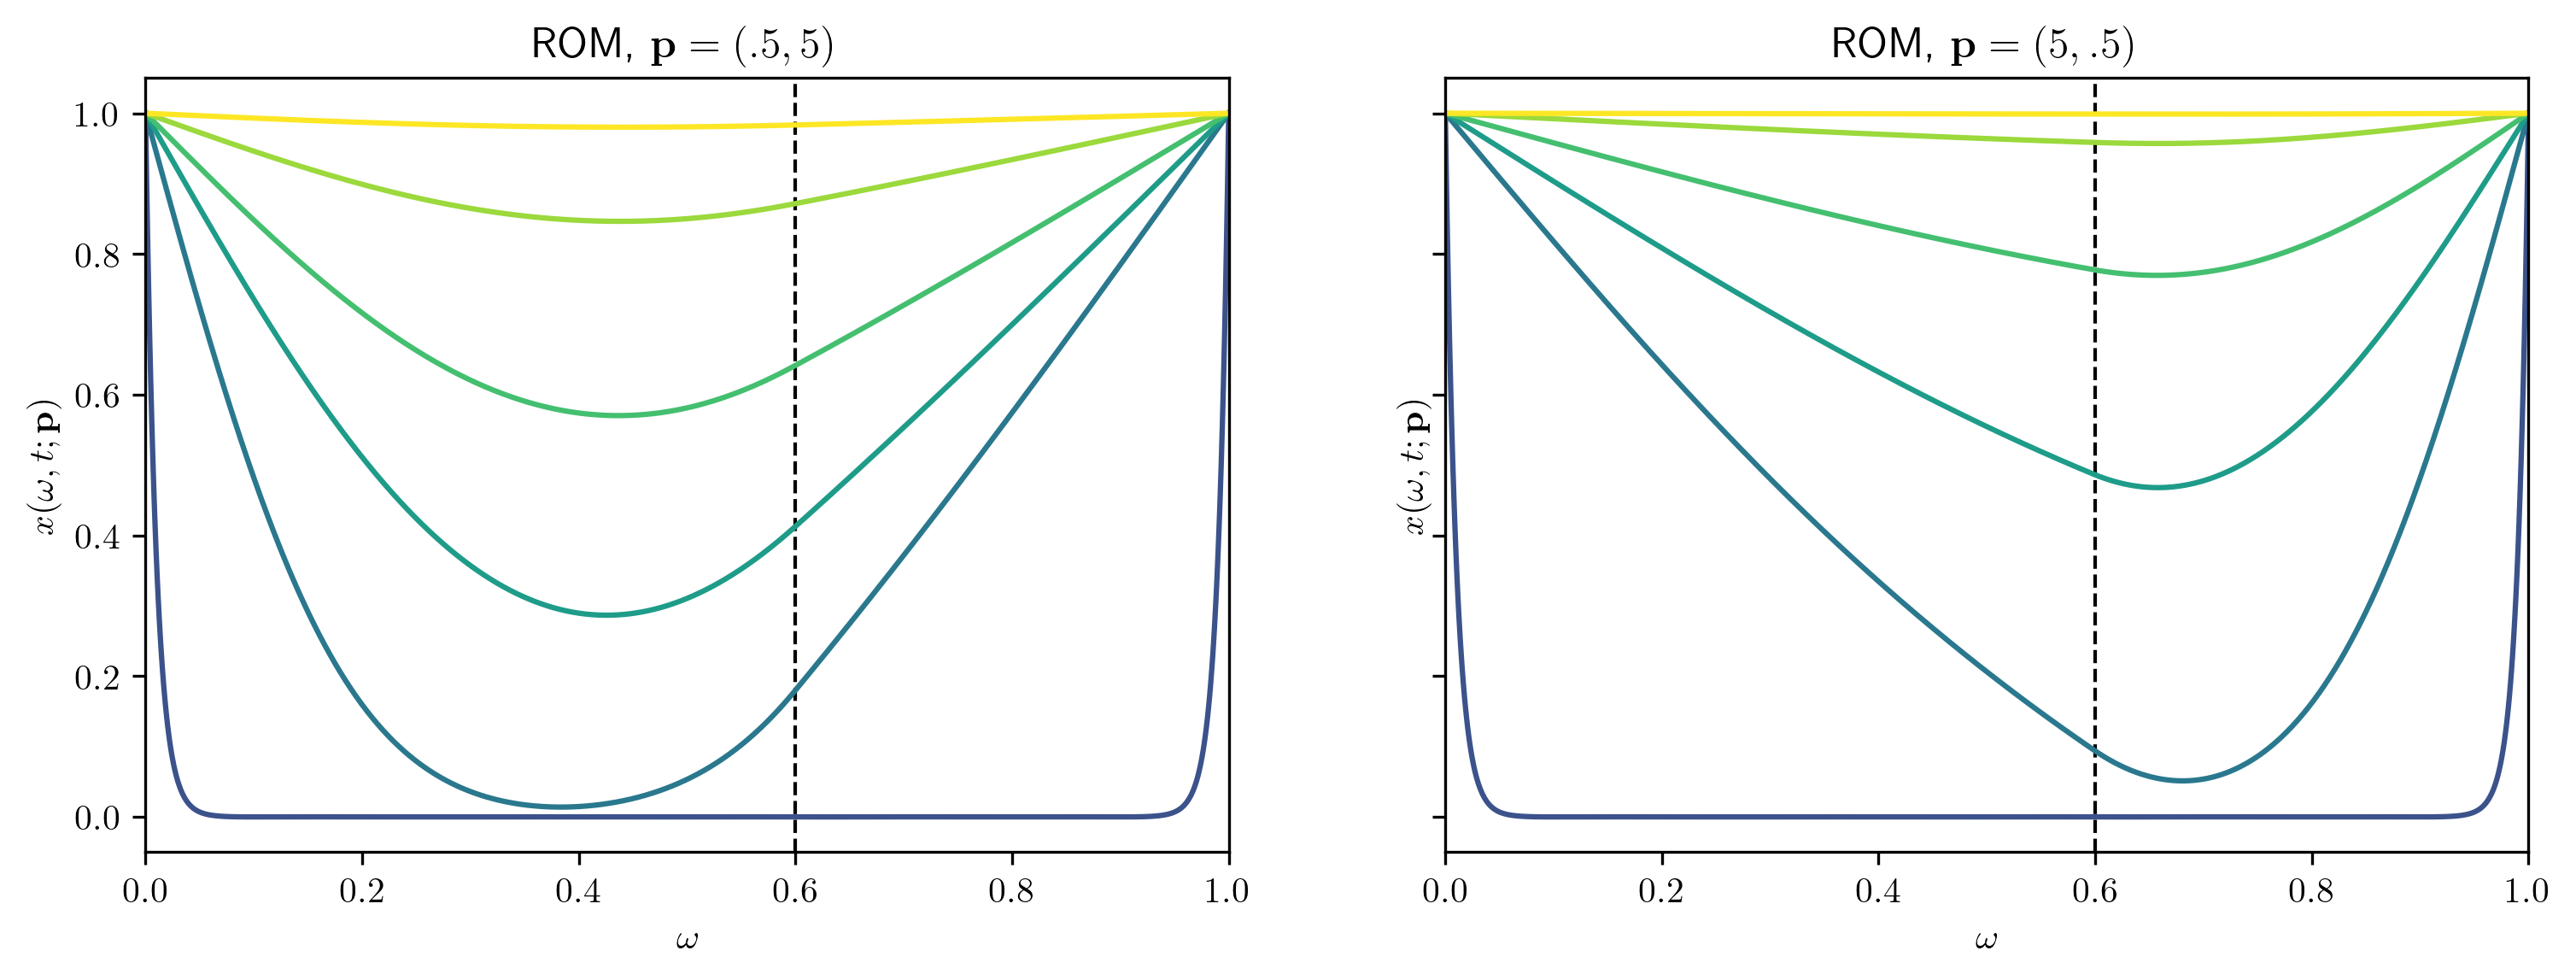

In [20]:
fig, [ax1, ax2] = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,4))

plot_heat_data(ROM([.5, 5]), r"ROM, $\mathbf{p} = (.5, 5)$", [.6], ax1)
plot_heat_data(ROM([5, .5]), r"ROM, $\mathbf{p} = (5, .5)$", [.6], ax2)